Initial Imports


In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import fastcore.all as fc
from PIL import Image
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
    ToPILImage,
)
import tensorflow_datasets as tfds
from torch.utils.data import IterableDataset, DataLoader
import matplotlib.pyplot as plt


Image setup

In [2]:
img_size = 224
patch_size = 32


\Loading 

In [3]:
ds_train, info = tfds.load(
    "imagenette/320px", split="train", as_supervised=False, with_info=True
)
ds_val = tfds.load("imagenette/320px", split="validation", as_supervised=False)

2025-12-11 15:04:31.541320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 15:04:32.469971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765483473.463564   25588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765483473.580536   25588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765483474.707029   25588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
def transforms(img_size):
    return Compose(
        [
            RandomResizedCrop(
                size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2
            ),
            RandomHorizontalFlip(p=0.5),
            ToTensor(),
        ]
    )

In [5]:
def show_images(img_tensor, mask=None):
    if mask is None:
        mask = np.zeros((img_tensor.shape[0],))

    if len(img_tensor.shape) == 3:
        img_tensor = img_tensor.unsqueeze(dim=0)
    # print(img_tensor.shape[0])
    n_patches = int(np.ceil(np.sqrt(img_tensor.shape[0])))
    # print(n_patches)
    fig, ax = plt.subplots(n_patches, n_patches, figsize=(4, 4))
    ax = np.asarray(ax)
    flat_ax = ax.flatten()

    for n, i in enumerate(img_tensor):
        if mask[n] == 0:
            patch = ToPILImage()(i)
        else:
            patch = torch.zeros(*i.shape).permute((1, 2, 0))
        flat_ax[n].imshow(patch)
        flat_ax[n].axis("off")
    plt.show()

In [6]:
class TFDatasetWrapper(IterableDataset):
    def __init__(self, tf_dataset, transform=None, with_label=True):
        self.tf_dataset = tf_dataset
        self.with_label = with_label
        self.transform = transform

    def __iter__(self):
        # tfds.as_numpy converts TensorFlow tensors → NumPy arrays on the fly
        for sample in tfds.as_numpy(self.tf_dataset):
            # image = torch.tensor(sample["image"], dtype=torch.float32).permute(2, 0, 1)
            image = Image.fromarray(sample["image"])
            if self.transform is not None:
                image = self.transform(image)
            if self.with_label:
                label = torch.tensor(sample["label"], dtype=torch.long)
                yield image, label
            else:
                yield image

In [7]:
train_transform = transforms(img_size)
val_transform = transforms(img_size)
train_ds = TFDatasetWrapper(ds_train, train_transform, False)
val_ds = TFDatasetWrapper(ds_val, train_transform, False)

In [8]:
s = next(iter(train_ds))
s.shape

2025-12-11 15:04:51.607615: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


torch.Size([3, 224, 224])

In [9]:
train_loader = DataLoader(train_ds, batch_size=32)
val_loader = DataLoader(val_ds, batch_size=32)

In [10]:
next(iter(train_loader)).shape

torch.Size([32, 3, 224, 224])

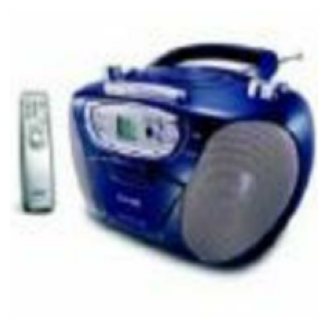

In [11]:
img_to_show = next(iter(train_loader))[0]
show_images(img_to_show)

torch.Size([49, 3, 32, 32])


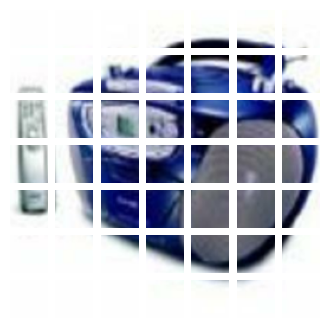

In [12]:
def patch_image(img):
    return (
        img.unfold(1, patch_size, patch_size)
        .unfold(2, patch_size, patch_size)
        .permute((0, 3, 4, 1, 2))
        .flatten(3)
        .permute((3, 0, 1, 2))
    )


patched_img = patch_image(img_to_show)
print(patched_img.shape)
show_images(patched_img)

In [13]:
tokens = patched_img.shape[0]
mask_ratio = 0.75
mask_count = int(tokens * mask_ratio)
print(f"{tokens} total tokens, {mask_count} masked patches")  # (49, 36)


49 total tokens, 36 masked patches


tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1])


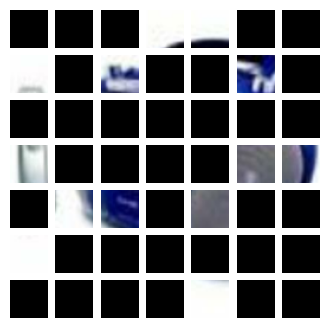

In [14]:
mask_idx = torch.randperm(tokens)[:mask_count]
mask = torch.zeros(tokens).long()
mask[mask_idx] = 1
print(mask)
show_images(patched_img, mask)

In [15]:
input_tokens = patched_img[~mask.bool(), ...]
print(input_tokens.shape)
input_tokens = input_tokens.flatten(1)
input_tokens.shape  # torch.Size([13, 3072])

torch.Size([13, 3, 32, 32])


torch.Size([13, 3072])

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            # We use conv for doing the patching
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                # if kernel_size = stride -> no overlap
                kernel_size=patch_size,
                stride=patch_size,
            ),
            # Linear projection of Flattened Patches. We keep the batch and the channels (b,c,h,w)
            nn.Flatten(2),
        )
        # self.cls_token = nn.Parameter(
        #     torch.randn(size=(1, 1, embed_dim)), requires_grad=True
        # )
        # self.position_embeddings = nn.Parameter(
        #     torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True
        # )
        # self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask=None):
        # Create a copy of the cls token for each of the elements of the BATCH
        # cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        if mask is not None:
            x = x[:, ~mask.bool(), :]
        # Unify the position with the patches
        # print(x.shape, cls_token.shape, self.position_embeddings.shape)
        # x = torch.cat([cls_token, x], dim=1)
        # # Patch + Position Embedding
        # x = self.position_embeddings + x
        # x = self.dropout(x)
        return x

In [17]:
image_to_test = next(iter(train_loader))[:1]
image_shape = image_to_test.shape[2:]
patch_shape = (32, 32)
embed_dim = 768
num_patches = (image_shape[0] // patch_shape[0]) * (image_shape[1] // patch_shape[1])
patch_embedder = PatchEmbedding(
    patch_size=patch_shape,
    embed_dim=embed_dim,
    in_channels=3,
    dropout=0.1,
    num_patches=num_patches,
)
input_tokens = patch_embedder(image_to_test, mask=mask)
print(input_tokens.shape, num_patches)

torch.Size([1, 13, 768]) 49


In [18]:
pos_embed = nn.Parameter(torch.zeros(num_patches, embed_dim), requires_grad=False)
print(pos_embed.shape)  # torch.Size([49, 768])

print(pos_embed[~mask.bool(), ...].shape)  # torch.Size([13, 768])

pos_input_tokens = input_tokens + pos_embed[~mask.bool(), ...]
print(pos_input_tokens.shape)  # torch.Size([13, 768])

torch.Size([49, 768])
torch.Size([13, 768])
torch.Size([1, 13, 768])


In [19]:
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
cls_token.shape  # torch.Size([1, 1, 768])
cls_token = cls_token.expand(input_tokens.shape[0], -1, -1)
print(cls_token.shape)
tokens = torch.cat([cls_token, pos_input_tokens], dim=1)
tokens.shape

torch.Size([1, 1, 768])


torch.Size([1, 14, 768])

In [20]:
from timm.models.vision_transformer import Block

block = Block(768, num_heads=12)
block

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=False)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [21]:
encodings = block(tokens)
print(encodings.shape)  # torch.Size([14, 768])

torch.Size([1, 14, 768])


In [22]:
decoder_embed_dim = 512
decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
print(decoder_embed)

decoder_tokens = decoder_embed(encodings)
print(decoder_tokens.shape)

Linear(in_features=768, out_features=512, bias=True)
torch.Size([1, 14, 512])


In [23]:
mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
torch.nn.init.normal_(mask_token, std=0.02)
mask_token.shape  # torch.Size([1, 512])

tokens = torch.zeros((1, num_patches, decoder_embed_dim))
tokens[:, ~mask.bool(), :] = decoder_tokens[:, 1:, :]
tokens[:, mask.bool(), :] = torch.cat(
    [mask_token] * (num_patches - (~mask.bool()).sum()), dim=1
)
tokens.shape  # torch.Size([1, 49, 512])

torch.Size([1, 49, 512])

In [24]:
decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim))
print(decoder_pos_embed.shape)  # torch.Size([1, 49, 512])

tokens = tokens + decoder_pos_embed
tokens.shape  # torch.Size([1, 49, 512])

torch.Size([1, 49, 512])


torch.Size([1, 49, 512])

In [25]:
tokens = torch.cat([decoder_tokens[:, :1, :], tokens], dim=1)
print(tokens.shape)  # torch.Size([50, 512])

decoder_num_heads = 8
decoder_block = Block(
    decoder_embed_dim, decoder_num_heads, 4, qkv_bias=True, norm_layer=nn.LayerNorm
)
decoder_block

torch.Size([1, 50, 512])


Block(
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=512, out_features=1536, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=512, out_features=512, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [ ]:
decoder_norm = nn.LayerNorm(decoder_embed_dim)
decoder_pred = nn.Linear(
    decoder_embed_dim, patch_size**2 * 3, bias=True
)  # decoder to patch
decoder_pred
# Linear(in_features=512, out_features=3072, bias=True)


Linear(in_features=512, out_features=3072, bias=True)

In [28]:
out_tokens = decoder_block(tokens).squeeze(0)
out = decoder_norm(out_tokens.unsqueeze(0)).squeeze(0)
# predictor projection
out = decoder_pred(out)
out.shape  # torch.Size([50, 3072])

final_img_predictions = out[1:, :]  # remove mask tokens
final_img_predictions.shape  # torch.Size([49, 3072])

torch.Size([49, 3072])

In [29]:
print(image_to_test.shape)
inputs = patch_image(image_to_test.squeeze(0)).flatten(1)
print(inputs.shape, final_img_predictions.shape, mask.shape)
# (torch.Size([49, 3072]), torch.Size([49, 3072]), torch.Size([49]))


mean = inputs.mean(dim=-1, keepdim=True)
var = inputs.var(dim=-1, keepdim=True)
inputs = (inputs - mean) / (var + 1.0e-6) ** 0.5
inputs.shape  # torch.Size([49, 3072])

torch.Size([1, 3, 224, 224])
torch.Size([49, 3072]) torch.Size([49, 3072]) torch.Size([49])


torch.Size([49, 3072])

In [30]:
token_level_loss = ((final_img_predictions - inputs) ** 2).mean(dim=-1)
print(token_level_loss)

loss = (token_level_loss * mask).sum() / mask.sum()
print(loss)

tensor([1.3326, 1.3083, 1.3031, 1.3217, 1.3224, 1.3201, 1.2817, 1.3518, 1.3481,
        1.3554, 1.3633, 1.3339, 1.2677, 1.3134, 1.3555, 1.3527, 1.3334, 1.3140,
        1.3135, 1.3418, 1.3705, 1.3368, 1.3682, 1.3646, 1.3163, 1.3314, 1.2969,
        1.3208, 1.3244, 1.3676, 1.3409, 1.3535, 1.3385, 1.3128, 1.3252, 1.3470,
        1.3240, 1.3510, 1.3519, 1.3463, 1.3154, 1.3194, 1.3633, 1.3598, 1.3375,
        1.2952, 0.3228, 0.3382, 0.3382], grad_fn=<MeanBackward1>)
tensor(1.2784, grad_fn=<DivBackward0>)
